# Training the speech synthesis model

## Loading and cleaning spectrogram data

The first step that will be needed is to load spectrogram data. Since some files are missing, a few of the spectrograms will be completely empty and we would like to remove those.

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn, Block
from util import audio
import matplotlib.pyplot as plt
import pickle

C:\Users\dougl_000\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if 

In [2]:
#load everything
#lstTextEncodings = np.load('data/lsttxtencodingsSmall.npy')
#lst_linspectrograms = np.load('data/lstlinspectrogramsSmall.npy')
#lst_melspectrograms = np.load('data/lstmelspectrogramsSmall.npy')
lstTextEncodings = pickle.load( open( "data/lsttxtencodings.p", "rb" ) )
lst_linspectrograms = pickle.load( open( "data/lstlinspectrograms.p", "rb" ) )
lst_melspectrograms = pickle.load( open( "data/lstmelspectrograms.p", "rb" ) )

Let us do some sanity check. We know that audio 400 is:

She never @ went back to school , # even later on when both of their sons were older , @ # and she thinks that Jeff's criticisms grew out of what he saw as her lack @ of ambition . # 

File: HAW-157-02

In [3]:
linspectrogram = lst_linspectrograms[400]
melspectrogram = lst_melspectrograms[400]

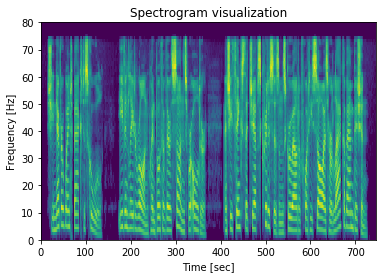

In [4]:
plt.pcolormesh(melspectrogram)
plt.title('Spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

We can also synthesize the audio to make sure it corresponds to what it should.

In [5]:
%%time
reconst_wav = audio.inv_spectrogram(linspectrogram)

C:\Users\dougl_000\Anaconda3\lib\site-packages\librosa\util\utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


Reconstructing with 60 iterations
Wall time: 18.1 s


In [6]:
audio.save_wav(path='data/reconstrSANITYTrain.wav', wav=reconst_wav)

Let us now find and delete rows that correspond to blanks.

In [7]:
emptyIdx = []
for i in range(len(lst_linspectrograms)):
    spec = lst_linspectrograms[i]
    if np.count_nonzero(spec) == 0:
        #print('{}-th index is all zeros'.format(i))
        emptyIdx.append(i)
print(len(emptyIdx))

53


In [8]:
#lstTextEncodingsProc = np.delete(lstTextEncodings,emptyIdx,0)
#lst_linspectrograms = np.delete(lst_linspectrograms,emptyIdx,0)
#lst_melspectrograms = np.delete(lst_melspectrograms,emptyIdx,0)
lstTextEncodingsProc = [i for j, i in enumerate(lstTextEncodings) if j not in emptyIdx]
lst_linspectrograms = [i for j, i in enumerate(lst_linspectrograms) if j not in emptyIdx]
lst_melspectrograms = [i for j, i in enumerate(lst_melspectrograms) if j not in emptyIdx]

One last thing: if not all files have been processed, the text encodings will have more samples than the spectrograms.

In [9]:
lstTextEncodingsProc = lstTextEncodingsProc[:len(lst_linspectrograms)]
len(lstTextEncodingsProc)

759

In [10]:
nmax = 500
lstTextEncodingsProc = lstTextEncodingsProc[:nmax]
lst_linspectrograms = lst_linspectrograms[:nmax]
lst_melspectrograms = lst_melspectrograms[:nmax]
len(lst_melspectrograms)

500

In [11]:
#np.save('data/lstlinspectrogramsSmall.npy', lst_linspectrograms)
#np.save('data/lstmelspectrogramsSmall.npy', lst_melspectrograms)
#np.save('data/lsttxtencodingsSmall.npy', lstTextEncodings)

In [12]:
import psutil
mem = psutil.virtual_memory()
mem.available/mem.total

0.2481699165493725

## Creating mxnet dataloader

MXNet Dataloaders can read data from numpy arrays.
See https://mxnet.incubator.apache.org/tutorials/gluon/datasets.html

However, the dataloader has a hard time iterating through items of different length.

In [13]:
voicedataset = mx.gluon.data.dataset.ArrayDataset(lstTextEncodingsProc, lst_linspectrograms, lst_melspectrograms)

In [14]:
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()

#data_loader = mx.gluon.data.DataLoader(voicedataset, batch_size=8, num_workers=CPU_COUNT)

#for X_batch, y_batch in data_loader:
#    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

# Create the model

TODO: Move to a .py file. How can we modify the constructor to receive the correct input/output sizes?

So the input has size (batch_size, sentence_length). It is worth noting that we will need to pad the sentende lengths to a constant size. Let us simulate an input

We will import gluon seq2seq from 
https://github.com/ZiyueHuang/MXSeq2Seq/blob/master/gluon/seq2seq.py

https://mxnet.incubator.apache.org/api/python/ndarray/ndarray.html

We will need to 'concat' and 'add' some results

In [15]:
ctx = mx.cpu()

In [16]:
batch_test = [np.array([1,2,3,1,2,6])]
batch_test.append(np.array([3,2,1,1,5]))
batch_test.append(np.array([3,1,2,6]))
batch_test.append(np.array([1,2,2,6]))
batch_test.append(np.array([1,4,]))

curlen = len(batch_test)
for i in range(32-curlen):
    batch_test.append(np.array([1,4,4]))

batch_test[:6]

[array([1, 2, 3, 1, 2, 6]),
 array([3, 2, 1, 1, 5]),
 array([3, 1, 2, 6]),
 array([1, 2, 2, 6]),
 array([1, 4]),
 array([1, 4, 4])]

In [17]:
target_mel = []
target_lin = []
for i in range(32):
    seqlen = np.random.randint(600)
    mel_spec = np.random.randn(80,seqlen)
    lin_spec = np.random.randn(1025,seqlen)
    target_mel.append(mel_spec)
    target_lin.append(lin_spec)

[x.shape for x in target_lin[:6]]

[(1025, 429), (1025, 556), (1025, 403), (1025, 563), (1025, 528), (1025, 539)]

## Embedding

We perform individual embedding of each sequence. Let's define an embedding layer here. Later on it will be part of the full net. Let's say for this part that the number of symbols we consider is 7 (in practice it would be 26 letters and a few symbols), to an embedding size of 9 (just because we need to debug this).

In [18]:
#vocab size, embedding dimension
embedding = nn.Embedding(input_dim=31, output_dim=256)
embedding.initialize()

In [19]:
#need to pad sequences to have the same length
batch_size = len(batch_test)
shapes = np.empty(batch_size, dtype = int)
for i in range(batch_size):
    shapes[i] = batch_test[i].shape[0]

max_sentence_len = shapes.max()

for i in range(batch_size):
    batch_test[i] = np.pad(batch_test[i], (0, max_sentence_len - batch_test[i].shape[0]), 'constant', constant_values=(0, 0))


batch_test[:7]

[array([1, 2, 3, 1, 2, 6]),
 array([3, 2, 1, 1, 5, 0]),
 array([3, 1, 2, 6, 0, 0]),
 array([1, 2, 2, 6, 0, 0]),
 array([1, 4, 0, 0, 0, 0]),
 array([1, 4, 4, 0, 0, 0]),
 array([1, 4, 4, 0, 0, 0])]

In [20]:
#pad spectrograms
specshapes = np.empty(batch_size, dtype = int)
for i in range(batch_size):
    specshapes[i] = target_mel[i].shape[1]
    
max_spec_w = specshapes.max()

for i in range(batch_size):
    target_mel[i] = np.pad(target_mel[i], ((0,0), (0, max_spec_w - target_mel[i].shape[1])), 'constant', constant_values=(0, 0))
    target_lin[i] = np.pad(target_lin[i], ((0,0), (0, max_spec_w - target_lin[i].shape[1])), 'constant', constant_values=(0, 0))
    
[x.shape for x in target_mel[:6]]

[(80, 567), (80, 567), (80, 567), (80, 567), (80, 567), (80, 567)]

In [21]:
#later on, we will need the specific order of encoding the 1st char of every seq, then the 2nd and so on
temp_chars = np.concatenate(batch_test).reshape(-1, max_sentence_len).transpose()
temp_chars = temp_chars.reshape(temp_chars.size)
temp_chars

array([1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1,
       2, 2, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
char_embeddings = embedding(nd.array(temp_chars, dtype='int32').as_in_context(ctx))
char_embeddings.shape

(192, 256)

In [23]:
#same embedding, same vectors, difference is zero
test=char_embeddings[0]-char_embeddings[1*5+2]
nd.sum(nd.multiply(test,test))


[0.]
<NDArray 1 @cpu(0)>

## Pre-net

FC-256-ReLU !Dropout(0.5)

FC-128-ReLU !Dropout(0.5)


In [24]:
class PreNet(gluon.Block):
    def __init__(self, **kwargs):
        super(PreNet, self).__init__(**kwargs)
        
        with self.name_scope():
            self.fc1 = nn.Dense(256, activation='relu', flatten=False)
            self.dp1 = nn.Dropout(rate=0.5)
            self.fc2 = nn.Dense(128, activation='relu', flatten=False)
            self.dp2 = nn.Dropout(rate=0.5)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        return x
    

In [25]:
prenet = PreNet()
prenet.initialize()

In [26]:
char_embeddings.shape

(192, 256)

We need to prepare the features for the upcoming conv filters. Right now we have shape (batch_size, embedding_size)
We need to add a CHANNEL dimension before convolutions, i.e., (batch_size, 1, embedding_size)

In [27]:
prefeats = prenet(char_embeddings)
prefeats = prefeats.reshape(prefeats.shape[0],1,prefeats.shape[1])
prefeats.shape

(192, 1, 128)

## CBHG Layer

Conv1D bank: K=16, conv-k-128-ReLU

Max pooling: stride=1, width=2

Conv1D projections: conv-3-128-ReLU  $\rightarrow$  conv-3-128-Linear

Highway net: 4 layers of FC-128-ReLU

Bidirectional GRU: 128 cells

In [28]:
class CBHG(Block):
    def __init__(self, hiddensize, K=16, batch_size=32):
        super(CBHG, self).__init__()
        self.K = K
        self.conv = []
        self.hiddensize = hiddensize
        with self.name_scope():
            
            #self.conv = []
            for k in range(self.K):
                #looks like we cant do 1,2,3: lets do 2, 4, 6, 8, ... instead
                self.conv.append ( nn.Conv1D(channels=1, kernel_size=2*k+2, padding=k+1, activation='relu') )
                self.register_child(self.conv[k])
                
            self.maxpool0 = nn.MaxPool1D(pool_size=2, strides=1)
            self.bn0 = nn.BatchNorm()
            
            #projections
            self.convProj1 = nn.Conv1D(channels=1, kernel_size=3, padding=1, activation='relu')
            self.convProj2 = nn.Conv1D(channels=1, kernel_size=3, padding=1, activation=None)
            
            #Highway net: 4 layers of FC-128-ReLU
            self.fc1 = nn.Dense(128, activation='relu', flatten=False)
            self.fc2 = nn.Dense(128, activation='relu', flatten=False)
            self.fc3 = nn.Dense(128, activation='relu', flatten=False)
            self.fc4 = nn.Dense(128, activation='relu', flatten=False)
            

            
            self.bidirecgru = gluon.rnn.GRU(hidden_size=self.hiddensize, num_layers=1, bidirectional=True)
            

    def forward(self, x, hidden, batch_size=32):
        
        xBkp = x
        
        y = []
        for k in range(self.K):
            y.append ( self.conv[k](x) )
            #print(y[k].shape)
            
        for k in range(self.K-1):
            y[0] = mx.ndarray.concat(y[0], y[k+1])
        
        #print(y[0].shape)
        x = self.maxpool0(y[0])
        x = self.bn0(x)

        x = self.convProj1(x)
        x = self.convProj2(x)
        
        #residual connection
        x = xBkp + x
        
        #highway
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        #unstack 
        #print(x.shape)
        xx = x.reshape(-1, batch_size, x.shape[2])
        
        #print(xx.shape)
        #print(type(hidden))
        #print(hidden[0].shape)
        x, newhidden = self.bidirecgru(xx, hidden)
        #print(newhidden[0].shape)
        
        return x, newhidden
    def initHidden(self, ctx, batch_size=32):
        return [nd.zeros((2, batch_size, self.hiddensize)).as_in_context(ctx)]

In [29]:
cbhg = CBHG(128)
cbhg.initialize()
hidden = cbhg.initHidden(ctx)

C:\Users\dougl_000\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\block.py:382: UserWarning: "CBHG.conv" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  self.collect_params().initialize(init, ctx, verbose, force_reinit)


In [30]:
out, hidden = cbhg(prefeats, hidden)
print('shapes: out {}, hidden {}'.format(out.shape, hidden[0].shape))

shapes: out (6, 32, 256), hidden (2, 32, 128)


In [31]:
encoderout, hidden = cbhg(prefeats, hidden)
print('shapes: out {}, hidden {}'.format(encoderout.shape, hidden[0].shape))

shapes: out (6, 32, 256), hidden (2, 32, 128)


## Decoder net

In [32]:
attentionRNN = rnn.GRU(hidden_size=256)
attentionRNN.initialize()
attHidden = nd.zeros((1, batch_size, 256)).as_in_context(ctx)

In [33]:
attout, newAttHidden = attentionRNN(encoderout, attHidden)

In [34]:
ndtarget_mel= nd.array(np.stack(target_mel).transpose((0,2,1))).as_in_context(ctx)
print(ndtarget_mel.shape)
ndtarget_lin= nd.array(np.stack(target_lin).transpose((0,2,1))).as_in_context(ctx)
print(ndtarget_lin.shape)

(32, 567, 80)
(32, 567, 1025)


In [35]:
class DecoderNet(gluon.Block):
    def __init__(self, batch_size=32, **kwargs):
        super(DecoderNet, self).__init__(**kwargs)
        
        with self.name_scope():
            self.prenet = PreNet()
            self.attRNN = rnn.GRU(hidden_size=256, num_layers=1)
            self.decoderRNN = rnn.GRU(hidden_size=256, num_layers=2)
            self.fc = nn.Dense(160, flatten=False) #predict 2 mel_specs per time
            self.CBHGdec = CBHG(K=8, batch_size=batch_size, hiddensize=128)
            self.fc_mel2lin = nn.Dense(1025, flatten=False)
            
    def forward(self, ctx, attentionRNN, encoderOut, ndtarget_mel=None, mel_height = 80, batch_size=32, mel_width = 1800):
        #target_mel can be None during inference time
        
        #<Go> frame
        goframe = nd.zeros( (batch_size, mel_height) ).as_in_context(ctx)
        attHidden = nd.zeros((1, batch_size, 256)).as_in_context(ctx)
        decHidden = nd.zeros((2, batch_size, 256)).as_in_context(ctx)
        
        x = self.prenet(goframe)
        x = x.reshape(1,x.shape[0], x.shape[1])
        
        print(attHidden.shape)
        y, attHidden = attentionRNN(x, attHidden)

        #print(encoderOut.shape)
        #print(y.shape)
       
        z = nd.concat(encoderOut, y, dim=0)
        
        decRNNout, decHidden = self.decoderRNN(z, decHidden)
        
        melprediction = decRNNout[-1,:,:]
        melprediction = self.fc(melprediction)
        melprediction = melprediction.reshape(batch_size, 2, mel_height)    
        
        if (ndtarget_mel is not None):
            mel_width = ndtarget_mel.shape[1]
            

        for i in range((mel_width-1)//2):
            curframe = None
            if (ndtarget_mel is not None):
                curframe = ndtarget_mel[:,2*i]
            else:
                curframe = melprediction[:,-1,:]
                
            xx = self.prenet(curframe)
            xx = xx.reshape(1,xx.shape[0], xx.shape[1])
            yy, attHidden = self.attRNN(xx, attHidden)
            
            zz = nd.concat(encoderOut, yy, dim=0)
            
            decRNNout2, decHidden = self.decoderRNN(zz, decHidden)
            
            curmelprediction = decRNNout2[-1,:,:]
            curmelprediction = self.fc(curmelprediction)
            curmelprediction = curmelprediction.reshape(batch_size, 2, mel_height)
            
            melprediction = nd.concat(melprediction, curmelprediction, dim=1)
        
        melprediction = melprediction[:,:mel_width,:]
        
        #still need the cbhg to predict lin_mel
        melpredtransp = nd.transpose(melprediction, axes=(1,0,2))
        
        cbhgdechidden = self.CBHGdec.initHidden(ctx)
        linpredtransp, cbhgdechidden = self.CBHGdec(melpredtransp, cbhgdechidden)
        
        linprediction = nd.transpose(linpredtransp, axes=(1,0,2))
        
        #project linear spectrogram
        #print('linpred shape {} batchsize {} melwid {}'.format(linprediction.shape, batch_size, mel_width))
        linprediction = linprediction.reshape(batch_size*mel_width, 256)
        linprediction = self.fc_mel2lin(linprediction)
        linprediction = linprediction.reshape(batch_size, mel_width, 1025)
        
        return melprediction, linprediction


In [36]:
dcn = DecoderNet()
dcn.initialize()

C:\Users\dougl_000\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\block.py:296: UserWarning: "CBHG.conv" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  ret.update(cld.collect_params(select=select))


In [37]:
decoded, linpred = dcn(ctx, attentionRNN, encoderout, ndtarget_mel)
print('Shape: target mel {}, decoded {}'.format(ndtarget_mel.shape, decoded.shape))
print('Shape: target lin {}, decoded {}'.format(ndtarget_lin.shape, linpred.shape))

(1, 32, 256)


AssertionError: Expected shape (768, 128) is incompatible with given shape (768, 256).

In [38]:
linpred.shape

NameError: name 'linpred' is not defined

# Putting everything together

In [39]:
class TacotronNet(gluon.Block):
    def __init__(self, input_dim, batch_size=32, **kwargs):
        super(TacotronNet, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.cbhgenc_hidden = None
        
        
        with self.name_scope():
            self.embedding = nn.Embedding(input_dim=31, output_dim=256)
            self.prenet1 = PreNet()
            self.CBHGenc = CBHG(K=16, batch_size=batch_size, hiddensize=128)
            self.decodernet = DecoderNet()
            self.attentionRNNlayer = rnn.GRU(hidden_size=256)
            self.Att = rnn.GRU(hidden_size=256)
            
        self.initHiddenStates()
        
    def initHiddenStates(self):
        self.cbhgenc_hidden = self.CBHGenc.initHidden(ctx)
    
    def forward(self, x, ctx, ndtarget_mel=None, mel_height = 80, batch_size=32, mel_width = 1800):
        batch_test = x
        #need to pad sequences to have the same length
        batch_size = len(batch_test)
        shapes = np.empty(batch_size, dtype = int)
        for i in range(batch_size):
            shapes[i] = batch_test[i].shape[0]

        max_sentence_len = shapes.max()

        for i in range(batch_size):
            batch_test[i] = np.pad(batch_test[i], (0, max_sentence_len - batch_test[i].shape[0]), 'constant', constant_values=(0, 0))

        #later on, we will need the specific order of encoding the 1st char of every seq, then the 2nd and so on
        temp_chars = np.concatenate(batch_test).reshape(-1, max_sentence_len).transpose()
        temp_chars = temp_chars.reshape(temp_chars.size)
        
        char_embeddings = self.embedding(nd.array(temp_chars, dtype='int32').as_in_context(ctx))
        
        prefeats = self.prenet1(char_embeddings)
        prefeats = prefeats.reshape(prefeats.shape[0],1,prefeats.shape[1])
        
        encoding, enc_hidden = self.CBHGenc(prefeats, self.cbhgenc_hidden)
        self.cbhgenc_hidden = enc_hidden
        
        attHidden = nd.zeros((1, batch_size, 256)).as_in_context(ctx)
        attout, newAttHidden = self.attentionRNNlayer(encoding, attHidden)#attentionRNN(encoding, attHidden)
        
        decodedmel, decodedlin = self.decodernet(ctx, self.Att, attout, ndtarget_mel, mel_height, batch_size, mel_width)
            
        return decodedmel, decodedlin

In [40]:
tcn=TacotronNet(31)
tcn.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
tcn.initHiddenStates()

C:\Users\dougl_000\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\block.py:296: UserWarning: "CBHG.conv" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  ret.update(cld.collect_params(select=select))


In [41]:
decmel, declin = tcn(batch_test, ctx, ndtarget_mel)

(1, 32, 256)


In [42]:
print('Shape: target mel {}, decoded {}'.format(ndtarget_mel.shape, decmel.shape))
print('Shape: target lin {}, decoded {}'.format(ndtarget_lin.shape, declin.shape))

Shape: target mel (32, 567, 80), decoded (32, 567, 80)
Shape: target lin (32, 567, 1025), decoded (32, 567, 1025)


## Training

In [49]:
%run preprocess.py
ppt = PreProcessText('lowercaseonly')
nchars = len(ppt.validChars)
tcn=TacotronNet(nchars)

tcn.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

C:\Users\dougl_000\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\block.py:296: UserWarning: "CBHG.conv" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  ret.update(cld.collect_params(select=select))


In [50]:
desired_loss = gluon.loss.L1Loss()
scheduler = mx.lr_scheduler.FactorScheduler(1000, 0.9,1e-4)
trainer = gluon.Trainer(tcn.collect_params(), 'adagrad', {'learning_rate': .001, 'lr_scheduler': scheduler})

C:\Users\dougl_000\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\block.py:296: UserWarning: "CBHG.conv" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  ret.update(cld.collect_params(select=select))


In [51]:
print(len(lstTextEncodingsProc))
nbatches = 500 // 32 *32
batch_size

500


32

In [52]:
epochs=2
nbatches = 500 // batch_size * batch_size
for e in range(epochs):
    cumulative_loss = 0
    num_examples=1
    perm = np.random.permutation(len(lstTextEncodingsProc))

    for i in range(nbatches//batch_size):
        print(i)
        batchidxs = [perm[i*batch_size + j] for j in range(batch_size)]
        print(batchidxs)

        batchTest=[lstTextEncodingsProc[perm[i*batch_size + j]] for j in range(batch_size)]
        target_mel =[lst_melspectrograms[perm[i*batch_size + j]] for j in range(batch_size)]
        target_lin =[lst_linspectrograms[perm[i*batch_size + j]] for j in range(batch_size)]
        
        #pad spectrograms
        specshapes = np.empty(batch_size, dtype = int)
        for i in range(batch_size):
            specshapes[i] = target_mel[i].shape[1]

        max_spec_w = specshapes.max()

        for i in range(batch_size):
            target_mel[i] = np.pad(target_mel[i], ((0,0), (0, max_spec_w - target_mel[i].shape[1])), 'constant', constant_values=(0, 0))
            target_lin[i] = np.pad(target_lin[i], ((0,0), (0, max_spec_w - target_lin[i].shape[1])), 'constant', constant_values=(0, 0))       

        
        ndtarget_mel= nd.array(np.stack(target_mel).transpose((0,2,1))).as_in_context(ctx)
        ndtarget_lin= nd.array(np.stack(target_lin).transpose((0,2,1))).as_in_context(ctx)

        with autograd.record():
            print('btest {} tgtmel {}'.format(len(batch_test), ndtarget_mel.shape ))
            decoded_melspec, decoded_linspec = tcn(batch_test, ctx, ndtarget_mel)
            loss1 = desired_loss(decoded_melspec, ndtarget_mel)
            loss2 = desired_loss(decoded_linspec, ndtarget_lin)
            loss = loss1+loss2
            
        loss.backward()
        
        print('stepping')
        #TODO: see what is making grad stale
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
        num_examples +=1
        print('Loss = {} '.format(cumulative_loss/num_examples)) #, end='\r')
    


0
[154, 20, 37, 435, 339, 326, 226, 124, 444, 490, 298, 162, 432, 394, 260, 460, 307, 23, 62, 443, 187, 21, 301, 305, 211, 442, 141, 205, 90, 10, 387, 285]
btest 32 tgtmel (32, 1174, 80)
(1, 32, 256)
stepping
Loss = 7.1317362785339355 
1
[446, 494, 55, 401, 173, 311, 144, 438, 341, 484, 32, 75, 117, 60, 413, 433, 180, 218, 3, 148, 455, 5, 445, 370, 67, 252, 19, 106, 82, 346, 382, 265]
btest 32 tgtmel (32, 1126, 80)
(1, 32, 256)


MXNetError: [10:16:00] c:\projects\mxnet-distro-win\mxnet-build\3rdparty\dmlc-core\include\dmlc\./any.h:286: Check failed: type_ != nullptr The any container is empty requested=class mxnet::Imperative::AGInfo

fdgdffdcv
fdgdfg
fd
    


dfg


In [ ]:
epochs = 10

for e in range(epochs):
    cumulative_loss = 0
    num_examples=0
    for i, (data, linspec, melspec) in enumerate(data_loader):
        data = data.as_in_context(model_ctx).reshape(data.shape[0],1,data.shape[1])
        label = linspec.as_in_context(model_ctx)
        
        #print(label.shape)
        label = label[:,:outshape[2],:outshape[3]]
        
        
        with autograd.record():
            #print(data.shape)
            output = sdnn(data)
            
            #print(output.shape)
            #print(label.shape)
            
            loss = quadratic_loss(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
        num_examples +=1
        print('Loss = {} '.format(cumulative_loss/num_examples), end='\r')


    test_accuracy = 0 #evaluate_accuracy(test_data, net)
    train_accuracy = 0 #evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

In [321]:
x = cbhg(prefeats) #this is before the RNN layer, to test the order of elements for embedding (row-major or column-major). 
#we need the transpose in the beginning to encode all 0th chars then all 1st etc 
x


[[[1.0603712e-04 0.0000000e+00 8.0406735e-06 ... 0.0000000e+00
   1.6494501e-04 0.0000000e+00]]

 [[8.7798704e-05 3.4369252e-05 0.0000000e+00 ... 2.0515472e-08
   1.9162227e-04 1.4546076e-05]]

 [[8.7798704e-05 3.4369252e-05 0.0000000e+00 ... 2.0515472e-08
   1.9162227e-04 1.4546076e-05]]

 ...

 [[1.5011962e-04 6.4531319e-05 0.0000000e+00 ... 0.0000000e+00
   1.9514479e-04 0.0000000e+00]]

 [[1.5011962e-04 6.4531319e-05 0.0000000e+00 ... 0.0000000e+00
   1.9514479e-04 0.0000000e+00]]

 [[1.5011962e-04 6.4531319e-05 0.0000000e+00 ... 0.0000000e+00
   1.9514479e-04 0.0000000e+00]]]
<NDArray 30x1x128 @cpu(0)>

In [322]:
y = x.reshape(max_sentence_len, -1, x.shape[2])
y.shape

(6, 5, 128)

In [302]:
#x[i+batch_size*j] -> embedding of jth char of ith sentence
#x[0+batch_size*2] = x[10] = 2th char of 0th sentence 


#(sequence_length, batch_size, input_size) -> y
#y[i][j] -> i-th character of j-th sentence
#y[2][0] -> 2nd char of 0-th sentence 

In [303]:
x.shape

(30, 1, 128)

In [327]:
y[2][1]-x[1+5*2]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 1x128 @cpu(0)>

In [309]:
xx=np.arange(30).reshape(6,5)
xx[0]

array([0, 1, 2, 3, 4])

In [19]:
%run seq2seq.py
#rnnTest = EncoderRNN (input_size=input_size, hidden_size=256, n_layers=3)
#attTest = AttnDecoderRNN(hidden_size=256, output_size=512, n_layers=3, max_length=20, dropout_p=0.01)

In [20]:
model_ctx = mx.cpu()

In [21]:
#TODO
output_size = np.array([1025,1800])#linspectrogram.shape
input_size  = 2000 #lstTextEncodingsProc[0].shape[0]



class DNN(gluon.Block):
    def __init__(self, **kwargs):
        super(DNN, self).__init__(**kwargs)
        with self.name_scope():
            
            #encoding
            self.embedding = nn.Embedding(input_size, 256)
            self.flatten = nn.Flatten()
            
            #pre-net
            self.dense0 = nn.Dense(256, activation="relu")
            self.dense1 = nn.Dense(128, activation="relu")
            
            #CBHG
            self.maxpool0 = nn.MaxPool1D(pool_size=2, strides=1)
            self.conv = []
            for k in range(15):
                self.conv.append ( nn.Conv1D(channels=1, kernel_size=k+1, padding=0, activation='relu') )

            self.bn0 = gluon.nn.BatchNorm()
            
            
            self.conv1 = gluon.nn.Conv2D(channels=50, kernel_size=3, activation='relu')
            self.maxpool1 = gluon.nn.MaxPool2D(pool_size=2, strides=2)
            self.bn1 = gluon.nn.BatchNorm()
            self.drop = gluon.nn.Dropout(0.01)

            self.conv2 = gluon.nn.Conv2D(channels=100, kernel_size=3, activation='relu')
            self.maxpool2 = gluon.nn.MaxPool2D(pool_size=2, strides=2)
            self.bn2 = gluon.nn.BatchNorm()

            self.out = gluon.nn.Dense(10)
            

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        
        #pre-net
        x = self.dense0(x)
        x = self.dense1(x)
        
        #CBHG
        x = self.maxpool0(x)
        y = []
        for k in range(15):
            y.append ( self.conv[k](x) )

        #concatenate
        for k in range(14):
            mx.ndarray.concat(y[0], y[k],axis=0)
        
        x = self.bn0(y[0])
        
        ########todo
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.bn1(x)
        x = self.drop(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.bn2(x)

        
        x = self.flatten(x)

        x = self.out(x)
        return x
    


In [22]:
#TODO
class CBHG(Block):
    def __init__(self, K=16, inputSize=128):
        super(CBHG, self).__init__()
        self.K = K
        self.conv = []
        self.inputSize = inputSize;
        self.hiddenSize = inputSize;
        with self.name_scope():
            
            self.flatten0 = nn.Flatten()

                
            #self.conv = []
            for k in range(self.K):
                #looks like we cant do 1,2,3: lets do 1, 3, 5, 7, ... instead
                self.conv.append ( nn.Conv1D(channels=1, kernel_size=2*k+1, padding=k, activation='relu') )
                self.register_child(self.conv[k])
                
            self.maxpool0 = nn.MaxPool1D(pool_size=2, strides=1)
            self.bn0 = nn.BatchNorm()
            
            self.flatten = nn.Flatten()
            
            #Highway net: 4 layers of FC-128-ReLU
            self.fc1 = nn.Dense(self.inputSize, activation='relu')
            self.fc2 = nn.Dense(self.inputSize, activation='relu')
            self.fc3 = nn.Dense(self.inputSize, activation='relu')
            self.fc4 = nn.Dense(self.inputSize, activation='relu')
            
            #TODO: update this to a bidirectional RNN
            self.bidirecgru = gluon.rnn.GRU(hidden_size=self.hiddenSize, num_layers=1, bidirectional=True)
            

    def forward(self, x, hidden):
        #remember that prenet outputs 128 elements
        x_bkp = self.flatten0(x);
        
        y = []
        for k in range(self.K):
            y.append ( self.conv[k](x) )
            #print(y[k].shape)
            
        for k in range(self.K-1):
            y[0] = mx.ndarray.concat(y[0], y[k])
        
        #print(y[0].shape)
        x = self.maxpool0(y[0])
        x = self.bn0(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        print(x.shape)
        print(x_bkp.shape)
        
        x = x_bkp + x
        
        x, hidden = self.bidirecgru(x, hidden)
        
        return x, hidden
    def initHidden(self, ctx):
        return [nd.zeros((1, 1, self.hiddenSize), ctx=ctx)]

In [99]:
class SpeechDNN(gluon.Block):
    def __init__(self, input_size, specH, specW):
        super(SpeechDNN, self).__init__()
        
        self.specH = specH
        self.specW = specW
        
        with self.name_scope():
            
            #encoding
            self.embedding = nn.Embedding(input_size, 256)
            
            self.conv00 = gluon.nn.Conv2D(channels=20, kernel_size=(1,15), activation='relu')
            self.maxpool00 = gluon.nn.MaxPool2D(pool_size=2, strides=(1,1))
            self.bn00 = gluon.nn.BatchNorm()

            self.conv01 = gluon.nn.Conv2D(channels=10, kernel_size=(1,15), activation='relu')
            self.maxpool01 = gluon.nn.MaxPool2D(pool_size=2, strides=(2,1))
            self.bn01 = gluon.nn.BatchNorm()

            
            self.conv0 = gluon.nn.Conv2D(channels=6, kernel_size=(3,3), activation='relu')
            self.maxpool0 = gluon.nn.MaxPool2D(pool_size=2, strides=(1,1))
            self.bn0 = gluon.nn.BatchNorm()

            self.conv1 = gluon.nn.Conv2D(channels=4, kernel_size=(3,3), activation='relu')
            self.maxpool1 = gluon.nn.MaxPool2D(pool_size=2, strides=(1,1))
            self.bn1 = gluon.nn.BatchNorm()

            self.conv2 = gluon.nn.Conv2D(channels=1, kernel_size=(3,3), activation='relu')
            self.bn2 = gluon.nn.BatchNorm()


    def forward(self, x):
        x = self.embedding(x)
        x = nd.transpose(x, axes = (0,1,3,2))
        
        x = self.conv00(x)
        x = self.maxpool00(x)
        x = self.bn00(x)

        x = self.conv01(x)
        x = self.maxpool01(x)
        x = self.bn01(x)

        #print('emb Shape is {}'.format(x.shape))

        x = nd.UpSampling(x, num_filter=1, scale=2,sample_type='nearest')
        x = self.conv0(x)
        x = self.maxpool0(x)
        x = self.bn0(x)

        #print('Shape is {}'.format(x.shape))

        x = nd.UpSampling(x, num_filter=1, scale=3,sample_type='nearest')
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.bn1(x)

        #print('Shape is {}'.format(x.shape))

        #x = nd.UpSampling(x, num_filter=1, scale=3,sample_type='nearest')
        x = self.conv2(x)
        x = self.bn2(x)

        #padh = self.specH - x.shape[2]
        #padw = self.specW - x.shape[3]
        #print('Final shape is {}'.format(x.shape))
        #x = nd.pad(x, mode="constant", constant_value=0, pad_width=(0,0,0,0,0,padh,0,padw))
        
        return x

In [100]:
testIn = nd.arange(330).reshape(1,1,330)
testIn.shape

(1, 1, 330)

In [101]:
testUp = nd.array([[1,2],[6,7]]).reshape(1,1,2,2)
nd.UpSampling(testUp, num_filter=1, scale=2,sample_type='nearest')
#nd.transpose(testUp, axes = (0,1,3,2))


[[[[ 1.  1.  2.  2.]
   [ 1.  1.  2.  2.]
   [ 6.  6.  7.  7.]
   [ 6.  6.  7.  7.]]]]
<NDArray 1x1x4x4 @cpu(0)>

In [102]:
nd.pad(testIn.reshape(1,1,1,330), mode="constant", constant_value=0, pad_width=(0,0,0,0,0,1,0,2)).shape

(1, 1, 2, 332)

In [103]:
sdnn = SpeechDNN(330, specH=1025, specW=1800)
sdnn.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)

In [104]:
outshape = sdnn(testIn).shape
outshape

(1, 1, 748, 1786)

## Training

Try to output anything really

In [125]:
quadratic_loss = gluon.loss.L2Loss()
scheduler = mx.lr_scheduler.FactorScheduler(1000, 0.9,1e-4)
trainer = gluon.Trainer(sdnn.collect_params(), 'adagrad', {'learning_rate': .09, 'lr_scheduler': scheduler})

In [126]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Loss()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx) #.reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [127]:
mem = psutil.virtual_memory()
mem.available/mem.total

0.8468507067834946

In [128]:
epochs = 10

for e in range(epochs):
    cumulative_loss = 0
    num_examples=0
    for i, (data, linspec, melspec) in enumerate(data_loader):
        data = data.as_in_context(model_ctx).reshape(data.shape[0],1,data.shape[1])
        label = linspec.as_in_context(model_ctx)
        
        #print(label.shape)
        label = label[:,:outshape[2],:outshape[3]]
        
        
        with autograd.record():
            #print(data.shape)
            output = sdnn(data)
            
            #print(output.shape)
            #print(label.shape)
            
            loss = quadratic_loss(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
        num_examples +=1
        print('Loss = {} '.format(cumulative_loss/num_examples), end='\r')


    test_accuracy = 0 #evaluate_accuracy(test_data, net)
    train_accuracy = 0 #evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.201668709517, Train_acc 0, Test_acc 0
Epoch 1. Loss: 0.169974621385, Train_acc 0, Test_acc 0
Epoch 2. Loss: 0.141636425629, Train_acc 0, Test_acc 0
Epoch 3. Loss: 0.127402819693, Train_acc 0, Test_acc 0
Epoch 4. Loss: 0.118584297597, Train_acc 0, Test_acc 0
Epoch 5. Loss: 0.109004791826, Train_acc 0, Test_acc 0
Epoch 6. Loss: 0.10628638044, Train_acc 0, Test_acc 0
Epoch 7. Loss: 0.104168759659, Train_acc 0, Test_acc 0
Epoch 8. Loss: 0.102717960253, Train_acc 0, Test_acc 0
Epoch 9. Loss: 0.101594161242, Train_acc 0, Test_acc 0


In [185]:
data, linspec, melspec = voicedataset[9]
linspec.shape

(1025, 1800)

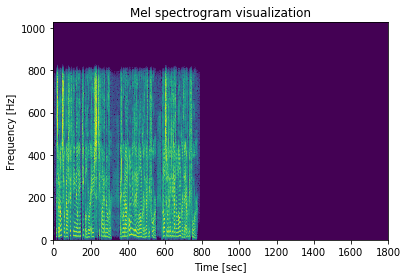

In [186]:
plt.pcolormesh(linspec)
plt.title('Mel spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [187]:
ndata = nd.array(data).reshape(1,1,data.shape[0])
ndata.shape

(1, 1, 330)

In [188]:
estimspec = sdnn(ndata.as_in_context(model_ctx)).asnumpy()
estimspec = estimspec.reshape( estimspec.shape[2], estimspec.shape[3]  )
#type(estimspec)
padh = linspec.shape[0] - estimspec.shape[0]
padw = linspec.shape[1] - estimspec.shape[1]
estimspec = np.pad(estimspec, ((0, padh), (0, padw)), 'constant')
estimspec.shape

(1025, 1800)

(1025, 1800)


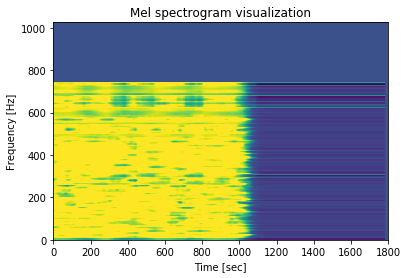

In [189]:
print(estimspec.shape)
plt.pcolormesh(estimspec)
plt.title('Mel spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [190]:
%%time
orig_wav = audio.inv_spectrogram(linspec)
audio.save_wav(path='genAudios/TTarget.wav', wav=orig_wav)

Reconstructing with 60 iterations
CPU times: user 20.7 s, sys: 120 ms, total: 20.8 s
Wall time: 20.7 s


In [191]:
%%time
reconst_wav = audio.inv_spectrogram(estimspec)
audio.save_wav(path='genAudios/TEstim.wav', wav=reconst_wav)

Reconstructing with 60 iterations
CPU times: user 20.7 s, sys: 0 ns, total: 20.7 s
Wall time: 20.7 s


In [181]:
linspec.max()

1.0

In [182]:
estimspec.max()

0.44388524